# t-SNE of Bayesian NN output

In this notebook, t-SNE is applied to sampled outputs of a Bayesian neural net.<br>
Based on the final trained state of the network a projection space is defined, and out-of-sample extension (OOSE) is used to project test data into that space.

## Import dependencies

Required modules:
- `sklearn.manifold` for standard t-SNE
- `kernel_method` for OOSE
- `numpy` for array functionality
- `scipy.spatial.distance` for pairwise distance function `pdist`
- `matplotlib.pyplot` for plotting results

Additional modules:
- `torch` for some more tensor manipulation
- `time` for timing operations (could be raplaced by `%time` in notebook)
- `os` to parse directory names and list files
- `PIL.Image` to create and export images
- `csv` and/or `json` for data export

In [1]:
from sklearn.manifold import TSNE
from kernel_method import KernelMap
import numpy as np
import scipy.spatial.distance as spdist
import matplotlib.pyplot as plt

import torch
import time
import os
from PIL import Image
import csv
import json

## Data import

Import the data exported from [`bayesian-mnist.ipynb`](bayesian-mnist.ipynb):
- [`training_outputs.npy`](exported-outputs/training_outputs.npy): 20 sampled outputs (10-dimensional) for each of 10000 training images
- [`training_outputs_epoch.npy`](exported-outputs/training_outputs_epoch.npy): same as above, but for each of 11 epochs
- [`test_outputs.npy`](exported-outputs/test_outputs.npy): 20 sampled outputs (10-dimensional) for each of 5000 test images

In [2]:
training_outputs = np.load('exported-data/training_outputs_NEW.npy')
training_outputs_epoch = np.load('exported-data/training_outputs_epoch_NEW.npy')
test_outputs = np.load('exported-data/test_outputs_NEW.npy')

training_inputs = np.load('exported-data/training_inputs.npy')
test_inputs = np.load('exported-data/test_inputs.npy')

In [4]:
last_epoch = torch.tensor(training_outputs_epoch[:,-1]).flatten(start_dim=0, end_dim=1).detach().numpy()

## Define distance function

Use angular distance for initial t-SNE (since most data points are concentrated at high-dimensional coordinate axis).
Also define some functions for Euclidean distance.

In [5]:
def norm(v):
    return np.sqrt(np.dot(v,v))

In [6]:
def cos_dist(u, v):
    arg = np.dot(u,v)/(norm(u)*norm(v))
    if arg > 1.:
        arg = 1.
    if arg < -1.:
        arg = -1.
    return np.arccos(arg)/np.pi

In [7]:
def euclidean(u, v):
    return norm(u-v)

## Set up t-SNE

Hyperparameters have to be chosen experimentally: `perplexity=20` and `learning_rate=1` seem to yield nice results consistently.

In [8]:
# possibly change to metric=cos_dist
output_tsne = TSNE(2, perplexity=40, learning_rate=1, metric='euclidean')

## Perform t-SNE

For reproducibility we `np.random.seed` first.

The initial t-SNE is performed on a subset only (`10*(1000/10)*10` data points, which should take about 3 min to calculate).

In [9]:
np.random.seed(42)
# training_output_subset = training_outputs.reshape(10,1000,20,10)[:,::10].reshape(-1,10)
%time projected_outputs = output_tsne.fit_transform(last_epoch)

KeyboardInterrupt: 

In [139]:
# tsne = TSNE(2, perplexity=20, learning_rate=1)

# np.random.seed(42)
# %time transformed_euclidean = tsne.fit_transform(training_output_subset)

Wall time: 46.5 s


# Check t-SNE results

Scatter plot of t-SNE-projected data, colored by known class.

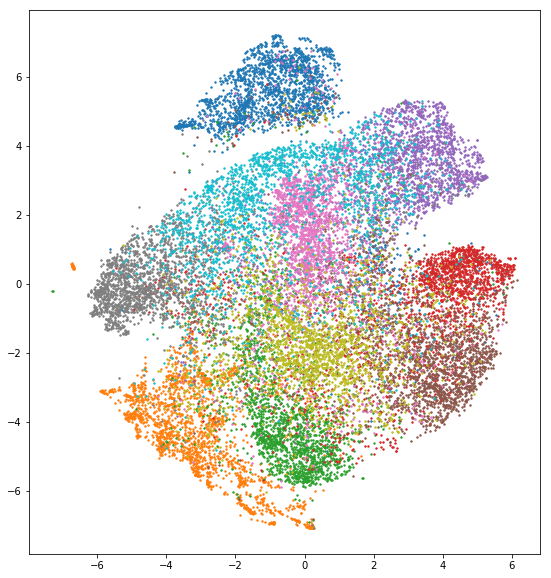

In [234]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
length = len(projected_outputs)//10
for i in range(10):
    ax.scatter(
        projected_outputs[i*length:(i+1)*length, 0],
        projected_outputs[i*length:(i+1)*length, 1],
        s=2
    )
ax.set_aspect('equal')
plt.show()

## Compare distances in high- and low-dimensional space

Two possible metrics:
- average of pairwise distances: `mean_pdist()`
    - this measure leads to better correlation between high-dimensional spread (cosine) and low dimensional spread (euclidean)
- average distance from center: `mean_dev()`

In [42]:
def mean_pdist(coords, metric=cos_dist):
    return spdist.pdist(coords, metric=metric).mean()

In [43]:
def mean_dev(coords, metric=cos_dist):
    avg = coords.mean(axis=0)
    distances = np.asarray([metric(i, avg) for i in coords])
    return distances.mean()

In [61]:
highdim_cos_spread = [mean_dev(i) for i in training_output_subset.reshape(-1,20,10)]

In [62]:
highdim_euclidean_spread = [mean_dev(i, metric=euclidean) for i in training_output_subset.reshape(-1,20,10)]

In [63]:
lowdim_cos_spread = [mean_dev(i) for i in projected_outputs.reshape(-1,20,2)]

In [64]:
lowdim_euclidean_spread = [mean_dev(i, metric=euclidean) for i in projected_outputs.reshape(-1,20,2)]

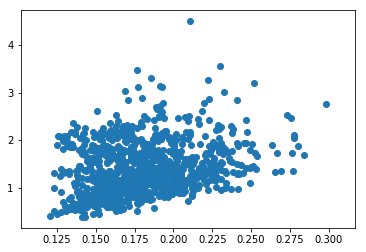

In [65]:
plt.scatter(highdim_cos_spread, lowdim_euclidean_spread)

In [66]:
np.corrcoef(highdim_cos_spread, y=lowdim_euclidean_spread)

array([[1.        , 0.28102909],
       [0.28102909, 1.        ]])

## Compute t-SNE for inputs

Calculate projections of image feature vectors (inputs) for same subset that was used for output projection above.

In [93]:
training_input_subset = training_inputs.reshape(10,1000,28,28)[:,::10].reshape(-1,28,28)

In [94]:
input_tsne = TSNE(2, perplexity = 5, learning_rate=1)

np.random.seed(42)
projected_input = input_tsne.fit_transform(training_input_subset.reshape(-1,28*28))

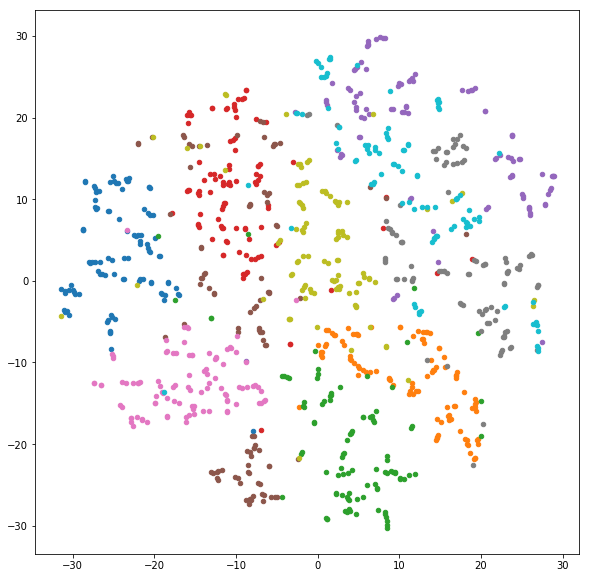

In [95]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
length = len(projected_input)//10
for i in range(10):
    ax.scatter(
        projected_input[i*length:(i+1)*length, 0],
        projected_input[i*length:(i+1)*length, 1],
        s=20
    )
ax.set_aspect('equal')
plt.show()

## 1-d t-SNE test

In [6]:
cos_tsne_id = TSNE(1, perplexity=20, learning_rate=1, metric=cos_dist)

In [7]:
np.random.seed(42)
training_output_subset = np.stack([i[::15] for i in training_outputs[:,::2].reshape(10,1000,10,10)]).reshape(-1,10)
%time projected_outputs = cos_tsne_id.fit_transform(training_output_subset)

Wall time: 3min 32s


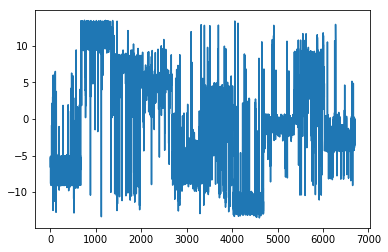

In [9]:
plt.plot(projected_outputs)

In [13]:
projected_outputs.reshape(10,-1).mean(axis=1)

array([ -5.621382 ,  10.8745775,   5.7846737,   4.708436 ,  -6.306394 ,
         0.3807424, -10.653616 ,  -0.6546088,   3.3188312,  -2.7269812],
      dtype=float32)

In [14]:
projected_outputs.reshape(10,-1).std(axis=1)

array([2.6540606, 2.5240917, 5.4115863, 2.2397275, 3.2638893, 3.9092078,
       3.4654372, 1.9218131, 3.3743532, 2.0816095], dtype=float32)

In [17]:
np.savetxt("foo.csv", projected_outputs, delimiter=",")

In [36]:
training_outputs_epoch.shape

(10000, 11, 20, 10)

## OOSE with kernel mapping

Train kernel-t-SNE on last data from epoch dataset.

In [215]:
from kernel_method import KernelMap

In [247]:
kernel_tsne = KernelMap(k_nb=40, local=True, sig_scale=0.5, metric='euclidean')

In [248]:
# high_dim = np.load('exported-data/tsne_input_training.npy')
# low_dim = np.load('exported-data/tsne_projected_training.npy')

high_dim = np.copy(last_epoch)
low_dim = np.copy(projected_outputs)

np.random.seed(42)
rng_state = np.random.get_state()
np.random.shuffle(high_dim)
np.random.set_state(rng_state)
np.random.shuffle(low_dim)

In [249]:
%time kernel_tsne.fit(high_dim[:3000], low_dim[:3000])

Wall time: 12.6 s


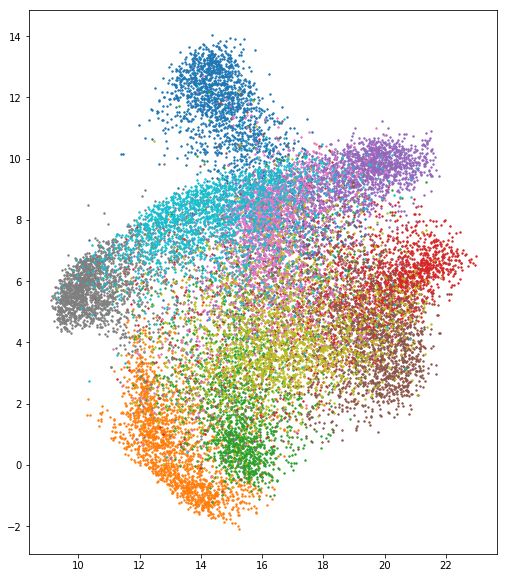

In [250]:
foo = kernel_tsne.transform(epoch_data_reshaped[-5,::10])

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
length = len(foo)//10
for i in range(10):
    ax.scatter(
        foo[i*length:(i+1)*length, 0],
        foo[i*length:(i+1)*length, 1],
        s=2
    )
ax.set_aspect('equal')
plt.show()

In [251]:
projected_epoch_data = np.stack([kernel_tsne.transform(epoch) for  epoch in torch.tensor(training_outputs_epoch).transpose(0,1)[:,::10].flatten(start_dim=1, end_dim=2).detach().numpy()])

In [122]:
projected_epoch_data.shape

(16, 20000, 2)

## Export data

Export projected outputs and projected inputs.<br>
Also export images with correct file names (corresponding to `'index'` property).

In [98]:
result = []
class_labels = [i for i in range(10) for _ in range(len(projected_input)//10)]
for index, p in enumerate(projected_input):
        entry = dict()
        entry['index'] = index
        entry['class'] = class_labels[index]
        entry['x'] = p[0].item()
        entry['y'] = p[1].item()
        result.append(entry)

In [100]:
with open('exported-data/training_inputs.json', 'w') as outfile:  
    json.dump(result, outfile)

In [124]:
result = []
class_labels = [i for i in range(10) for _ in range(len(training_output_subset)//10//10)]
for index, projections in enumerate(training_output_subset.reshape(-1,10,10)):
    for subindex, p in enumerate(projections):
        entry = dict()
        entry['index'] = index
        entry['class'] = class_labels[index]
        entry['x'] = transformed[10*index + subindex, 0].item()
        entry['y'] = transformed[10*index + subindex, 1].item()
        entry['hd_spread'] = highdim_cos_spread[index].item()
        entry['ld_spread'] = lowdim_euclidean_spread[index].item()
        result.append(entry)

In [126]:
with open('exported-data/training_outputs.json', 'w') as outfile:  
    json.dump(result, outfile)

In [132]:
for index, image in enumerate(training_input_subset):
    filename = 'exported-data/png/img-{:03}.png'.format(index)
    Image.fromarray(image*255).convert('RGB').save(filename)

In [138]:
class_labels = [i for i in range(10) for _ in range(len(projected_input)//10)]

In [252]:
training_outputs_epoch_subset = training_outputs_epoch.reshape(10,1000,16,20,10)[:,::10].reshape(-1,16,20,10)

In [256]:
complete_dataset = []
start_time = time.time()
for index, data in enumerate(torch.tensor(projected_epoch_data).view(16,1000,20,2).transpose(0,1).detach().numpy()):
    entry = dict()
    entry['index'] = index
    entry['classLabel'] = class_labels[index]
    entry['projectedInput'] = projected_input[index].tolist()
    subresult = []
    for epoch, outputs in enumerate(data):
        subentry = dict()
        subentry['epoch'] = epoch
        subentry['projectedOutputs'] = outputs.tolist()
        subentry['spread'] = {
            'lowDim': mean_pdist(outputs, metric='euclidean').item(),
            'highDim': mean_pdist(training_outputs_epoch_subset[index, epoch], metric='euclidean').item()
        }
        subresult.append(subentry)
    entry['epochData'] = subresult
    complete_dataset.append(entry)
print('Dict formatting complete. Time taken: {} s'.format(time.time()-start_time))

Dict formatting complete. Time taken: 0.9624247550964355 s


In [257]:
with open('exported-data/complete_data.json', 'w') as outfile:  
    json.dump(complete_dataset, outfile)

In [254]:
complete_dataset[5]

{'index': 5,
 'class': 0,
 'projectedInput': [-29.78668975830078, -1.4138257503509521],
 'epochData': [{'epoch': 0,
   'projectedOutputs': [[13.370903108238053, 12.589115133404903],
    [15.673038612382243, 9.807674900148868],
    [14.741684192646971, 13.643051686868148],
    [13.55703084238803, 13.26353583154787],
    [14.937160040103663, 11.978150766259205],
    [14.02576909706113, 12.73998396177194],
    [15.365960184005417, 12.318121086727388],
    [15.763748044903423, 12.23043767966874],
    [14.18343028939671, 9.791110315186415],
    [14.485120669080061, 12.758546868107715],
    [14.905654921128644, 12.049397443525322],
    [15.440612102982868, 9.19817887290651],
    [14.884640895678785, 10.597437045560355],
    [14.698786479614682, 13.50255597856085],
    [14.324190278326114, 13.071534073435032],
    [13.177338176741614, 11.92954767013589],
    [13.127498717683466, 13.361465126405392],
    [13.156145256322361, 10.65252545027306],
    [14.223393848465548, 13.28223902713853],
    